In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from functools import partial

from neural_nets.MLP import *
from neural_nets.CNN import * 

from inference.bnn import *
import inference.guides as guides
import inference.likelihoods as likelihoods
import inference.priors as priors
from inference.util import *

import examples.helpers as helpers

/home/neklein/anaconda3/envs/multiverse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


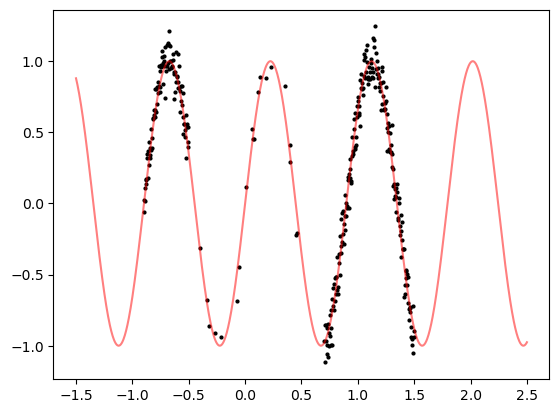

In [2]:
# Sinusoidal output
X_range = torch.linspace(-1.5,2.5,1000)
Y_true = torch.sin(X_range*7)

X_train = torch.cat((X_range[150:250], X_range[torch.randint(250,550,(20,)).sort().values], X_range[550:750]))

# create data
nprec = .1**-2
Y_train = torch.sin(X_train*7) + nprec**(-1/2)*torch.randn(X_train.shape[0])

plt.plot(X_train,Y_train,'o', color='black', markersize=2)
plt.plot(X_range,Y_true, color='red', alpha=0.5)

data = TensorDataset(X_train.unsqueeze(1),Y_train.unsqueeze(1))
batchsize = 16
train_loader = DataLoader(data, batch_size = batchsize, shuffle = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

## Linearized Laplace

In [3]:
wp = .1
n = X_train.shape[0]

prior = priors.IIDPrior((dist.StudentT(df=1, loc=torch.tensor(0., device=device), scale=torch.tensor(wp**-2, device=device))))
likelihood = likelihoods.HomoskedasticGaussian(n, precision=nprec)
net = MLP(in_dim=1, out_dim=1, width=10, depth=2, activation="tanh", device=device).to(device)
bayesian_mlp = LaplaceBNN(net, prior, likelihood, approximation='full')

In [4]:
# MAP training
optim = pyro.optim.ClippedAdam({"lr": 1e-2, "clip_norm": 100.0, "lrd": 0.999})
epochs = 500
nll_hist = bayesian_mlp.fit(train_loader, optim, epochs, num_particles=1,closed_form_kl=True, hist=True)
helpers.plot_nll(nll_hist)

  0%|          | 0/500 [00:01<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
f_predictions = bayesian_mlp.predict(X_range.unsqueeze(-1), num_predictions=100, aggregate=False)
y_predictions = bayesian_mlp.likelihood._point_predictions(f_predictions)

In [ ]:
helpers.plot_1d_gaussian_preds(y_predictions,X_range, train_x=X_train, train_y=Y_train, precision=nprec,method_name='Linearized Laplace')

In [ ]:
def predictive(input_data, num_samples=1):
    y_predictions = bayesian_mlp.likelihood.sample(bayesian_mlp.predict(input_data, num_predictions=num_samples))
    return y_predictions

In [ ]:
helpers.coverage(predictive, x_test=X_range.unsqueeze(-1), y_test=Y_true, x_train=X_train.unsqueeze(-1), y_train=Y_train, M=1000)

In [ ]:
bayesian_mlp.log_marginal_likelihood(train_loader)

In [ ]:
helpers.covariance_plots(bayesian_mlp)

## Hamiltonian Monte Carlo

In [ ]:
wp = 1.
nprec = .1**-2
n = X_train.shape[0]

prior = priors.IIDPrior((dist.Normal(torch.tensor(0., device=device), torch.tensor(wp ** -0.5, device=device))))
likelihood = likelihoods.HomoskedasticGaussian(n, precision=nprec)
kernel = pyro.infer.mcmc.NUTS
net = MLP(in_dim=1, out_dim=1, width=10, depth=2, activation="tanh").to(device)
hmc_mlp = MCMC_BNN(net, prior, likelihood, kernel_builder=kernel)

In [ ]:
warmup_steps = 50
num_samples = 50
num_chains = 1

mcmc = hmc_mlp.fit(train_loader, num_samples=num_samples, batch_data=True, warmup_steps=warmup_steps, num_chains = num_chains, disable_progbar=False).get_samples()
pred = hmc_mlp.predict(X_range.unsqueeze(-1),num_predictions=10, aggregate=False)

In [ ]:
helpers.plot_1d_gaussian_preds(pred,X_range, train_x=X_train, train_y=Y_train, precision=nprec,method_name='HMC')

In [ ]:
weights = helpers.samples_to_tensor(mcmc)
M = weights.shape[0]
# pick three posterior samples of weights
weights_for_plot = weights[[0, M//2, M-1]]

In [ ]:
helpers.loss_on_2d_subspace(train_loader, hmc_mlp, weights_for_plot, MC_chains=weights.unsqueeze(0), resolution=50, l_lim= -5)